# CNN

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2

#pip install --upgrade anvil-uplink
#pip install anvil

In [ ]:
mnist = tf.keras.datasets.mnist

# Load and preprocess data
(x_train_cnn, y_train_cnn), (x_test_cnn, y_test_cnn) = mnist.load_data()
x_train_cnn, x_test_cnn = x_train_cnn / 255.0, x_test_cnn / 255.0

ndata_train_cnn = x_train_cnn.shape[0]
ndata_test_cnn = x_test_cnn.shape[0]

x_train_cnn = x_train_cnn.reshape((-1, 28, 28, 1))
x_test_cnn = x_test_cnn.reshape((-1, 28, 28, 1))
xshape = x_train_cnn.shape[1:]


11490434/11490434 [==============================] - 0s 0us/step


In [ ]:

# Model configuration
CNNModel = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation=tf.nn.relu,input_shape=xshape),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation=tf.nn.relu),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l1(0.0002)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, activation=tf.nn.softplus, kernel_regularizer=tf.keras.regularizers.l1(0.0005)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

CNNModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0005)

CNNModel.summary()

# Fit the model with the ReduceLROnPlateau callback
CNNModel.fit(x_train_cnn, y_train_cnn, epochs=30, validation_split=0.2, batch_size=500, callbacks=[reduce_lr])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        2320      
                                                                 
 batch_normalization (Batch  (None, 24, 24, 16)        64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 32)        4

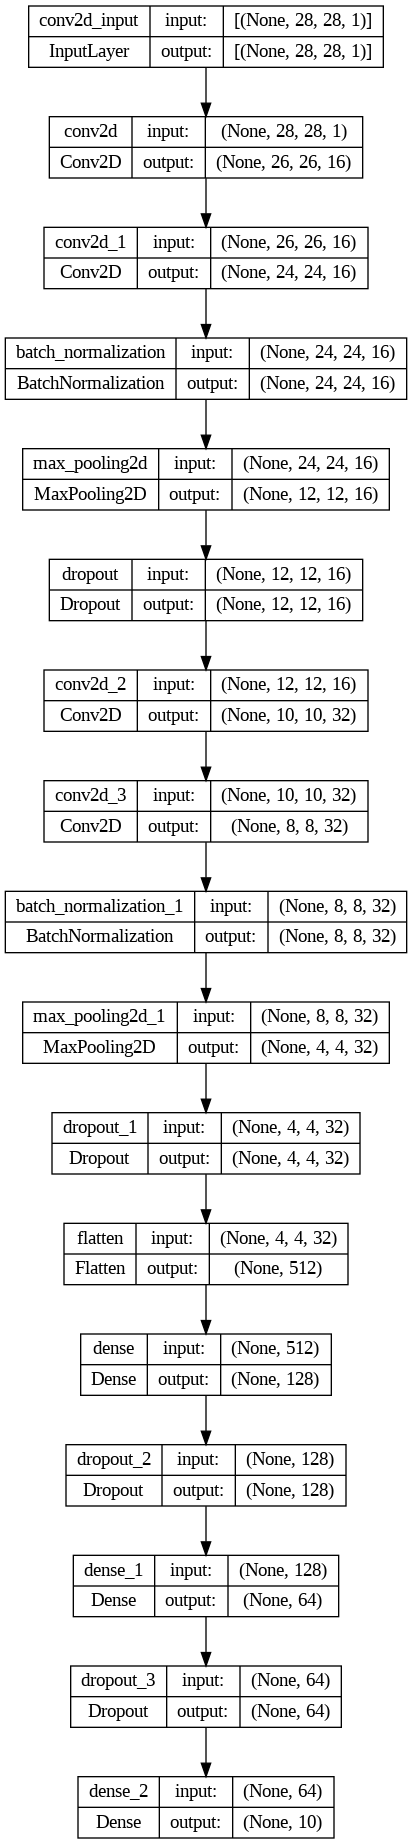

In [ ]:
from tensorflow.keras.utils import plot_model

# Visualize the model
plot_model(CNNModel, to_file='CNNModel_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
CNNModel.evaluate(x_test_cnn,y_test_cnn)[1]

313/313 [==============================] - 1s 3ms/step - loss: 0.1007 - accuracy: 0.9938


0.9937999844551086

# Transformer

In [ ]:
# this is written as a tensorflow "layer".  it's just a vector the same size as the
# output of the previous layer. the vector is initialized randomly, but we'll use
# gradient descent to update the values in the vector
#
# it's purpose is to be appended to the beginning of the sequence of vectors fed into
# the transformer.  then after the transformer runs on the whole data, we just grab
# the resulting zero-th vector...the class token...and use that as the portfolio weights
class ClassToken(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32),
            trainable = True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls

In [ ]:
def build_ViT(n,m,block_size,hidden_dim,num_layers,num_heads,key_dim,mlp_dim,dropout_rate,num_classes):
    # n is number of rows of blocks
    # m is number of cols of blocks
    # block_size is number of pixels (with rgb) in each block -> 4x4 = 16
    # hidden_dim -> size of the vector of the 0-10 processed image after first dense layer
    # num_heads -> number of multiple head(query, key, value) self attendtion
    # key_dim -> output dimension


    inp = tf.keras.layers.Input(shape=(n*m,block_size))
    # second input layer -> give the sequence to vectors
    inp2 = tf.keras.layers.Input(shape=(n*m))

    mid = tf.keras.layers.Dense(hidden_dim)(inp) # transform to vectors with different dimension
    # the positional embeddings
#     positions = tf.range(start=0, limit=n*m, delta=1)
    emb = tf.keras.layers.Embedding(input_dim=n*m, output_dim=hidden_dim)(inp2) # learned positional embedding for each of the n*m possible possitions

    #combine vector and its position information together
    mid = mid + emb # for some reason, tf.keras.layers.Add causes an error, but + doesn't?

    # create and append class token to beginning of all input vectors
    token = ClassToken()(mid) # append class token to beginning of sequence
    mid = tf.keras.layers.Concatenate(axis=1)([token, mid])

    for l in range(num_layers): # how many Transformer Head layers are there?
        ln  = tf.keras.layers.LayerNormalization()(mid) # normalize
        mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,key_dim=key_dim,value_dim=key_dim)(ln,ln,ln) # self attention! - same input (query, key, value) !
        add = tf.keras.layers.Add()([mid,mha]) # add and norm
        ln  = tf.keras.layers.LayerNormalization()(add)
        den = tf.keras.layers.Dense(mlp_dim,activation='gelu')(ln) # maybe should be relu...who knows...
        den = tf.keras.layers.Dropout(dropout_rate)(den) # regularization
        den = tf.keras.layers.Dense(hidden_dim)(den) # back to the right dimensional space
        den = tf.keras.layers.Dropout(dropout_rate)(den)
        mid = tf.keras.layers.Add()([den,add]) # add and norm again
    ln = tf.keras.layers.LayerNormalization()(mid)
    fl = ln[:,0,:] # just grab the class token for each image in batch
    clas = tf.keras.layers.Dense(num_classes,activation='softmax')(fl) # probability that the image is in each category
    mod = tf.keras.models.Model([inp,inp2],clas)
    mod.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return mod

In [ ]:
n = 7
m = 7
block_size = 16
hidden_dim = 64
num_layers = 6
num_heads = 4
key_dim = hidden_dim//num_heads # usually good practice for key_dim to be hidden_dim//num_heads...this is why we do Multi-Head attention
mlp_dim = 64
dropout_rate = 0.1
num_classes = 10

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor, e.g., 'val_loss' or 'val_accuracy'
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # verbosity mode
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)


trans = build_ViT(n,m,block_size,hidden_dim,num_layers,num_heads,key_dim,mlp_dim,dropout_rate,num_classes)
trans.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 49, 16)]             0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 49)]                 0         []                            
                                                                                                  
 dense_14 (Dense)            (None, 49, 64)               1088      ['input_3[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 49, 64)               3136      ['input_4[0][0]']             
                                                                                            

In [ ]:
(x_train_tf, y_train_tf),(x_test_tf, y_test_tf) = mnist.load_data()
x_train_tf, x_test_tf = x_train_tf / 255.0, x_test_tf / 255.0

ndata_train_tf = x_train_tf.shape[0]
ndata_test_tf = x_test_tf.shape[0]

x_train_ravel_tf = np.zeros((ndata_train_tf,n*m,block_size))
for img in range(ndata_train_tf):
    ind = 0
    for row in range(n):
        for col in range(m):
            x_train_ravel_tf[img,ind,:] = x_train_tf[img,(row*4):((row+1)*4),(col*4):((col+1)*4)].ravel() # turn 4x4 to 16 numbers
            ind += 1

x_test_ravel_tf = np.zeros((ndata_test_tf,n*m,block_size))
for img in range(ndata_test_tf):
    ind = 0
    for row in range(n):
        for col in range(m):
            x_test_ravel_tf[img,ind,:] = x_test_tf[img,(row*4):((row+1)*4),(col*4):((col+1)*4)].ravel()
            ind += 1

In [ ]:
pos_feed_train = np.array([list(range(n*m))]*ndata_train_tf)
pos_feed_test = np.array([list(range(n*m))]*ndata_test_tf)


In [ ]:
trans.fit([x_train_ravel_tf,pos_feed_train],y_train_tf,epochs=50,batch_size = 200,validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
240/240 [==============================] - 29s 44ms/step - loss: 0.9873 - accuracy: 0.6559 - val_loss: 0.4100 - val_accuracy: 0.8718
Epoch 2/50
240/240 [==============================] - 9s 39ms/step - loss: 0.3774 - accuracy: 0.8783 - val_loss: 0.2292 - val_accuracy: 0.9286
Epoch 3/50
240/240 [==============================] - 9s 37ms/step - loss: 0.2596 - accuracy: 0.9182 - val_loss: 0.1904 - val_accuracy: 0.9418
Epoch 4/50
240/240 [==============================] - 9s 38ms/step - loss: 0.1986 - accuracy: 0.9375 - val_loss: 0.1872 - val_accuracy: 0.9422
Epoch 5/50
240/240 [==============================] - 9s 38ms/step - loss: 0.1759 - accuracy: 0.9443 - val_loss: 0.1709 - val_accuracy: 0.9490
Epoch 6/50
240/240 [==============================] - 10s 42ms/step - loss: 0.1517 - accuracy: 0.9526 - val_loss: 0.1450 - val_accuracy: 0.9571
Epoch 7/50
240/240 [==============================] - 10s 40ms/step - loss: 0.1297 - accuracy: 0.9591 - val_loss: 0.1238 - val_accuracy: 0.9

In [ ]:
out = trans.evaluate([x_test_ravel_tf,pos_feed_test],y_test_tf)

313/313 [==============================] - 6s 15ms/step - loss: 0.0735 - accuracy: 0.9767


In [ ]:
out[1]

0.9767000079154968

### Train CNN with the Entire Dataset



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

In [ ]:
CNNModel.fit(x_train_cnn, y_train_cnn, epochs=30, batch_size=500)

# Evaluate on the test set
test_loss, test_acc = CNNModel.evaluate(x_test_cnn, y_test_cnn)
print(f"Test accuracy: {test_acc*100:.2f}%")

Epoch 1/30
120/120 [==============================] - 2s 16ms/step - loss: 0.1241 - accuracy: 0.9880
Epoch 2/30
120/120 [==============================] - 2s 16ms/step - loss: 0.1227 - accuracy: 0.9880
Epoch 3/30
120/120 [==============================] - 2s 15ms/step - loss: 0.1232 - accuracy: 0.9879
Epoch 4/30
120/120 [==============================] - 2s 15ms/step - loss: 0.1198 - accuracy: 0.9887
Epoch 5/30
120/120 [==============================] - 2s 15ms/step - loss: 0.1213 - accuracy: 0.9881
Epoch 6/30
120/120 [==============================] - 2s 16ms/step - loss: 0.1175 - accuracy: 0.9893
Epoch 7/30
120/120 [==============================] - 2s 16ms/step - loss: 0.1175 - accuracy: 0.9883
Epoch 8/30
120/120 [==============================] - 2s 15ms/step - loss: 0.1168 - accuracy: 0.9884
Epoch 9/30
120/120 [==============================] - 2s 15ms/step - loss: 0.1162 - accuracy: 0.9887
Epoch 10/30
120/120 [==============================] - 2s 16ms/step - loss: 0.1149 - accura

### Visualization of CNN Missclassification

In [ ]:
# Make predictions
predictions_cnn = CNNModel.predict(x_test_cnn)
predicted_classes_cnn = np.argmax(predictions_cnn, axis=1)

# Find indices of misclassified digits
misclassified_indices_cnn = np.where(predicted_classes_cnn != y_test_cnn)[0]

313/313 [==============================] - 1s 3ms/step


Total number of misclassification cases: 56


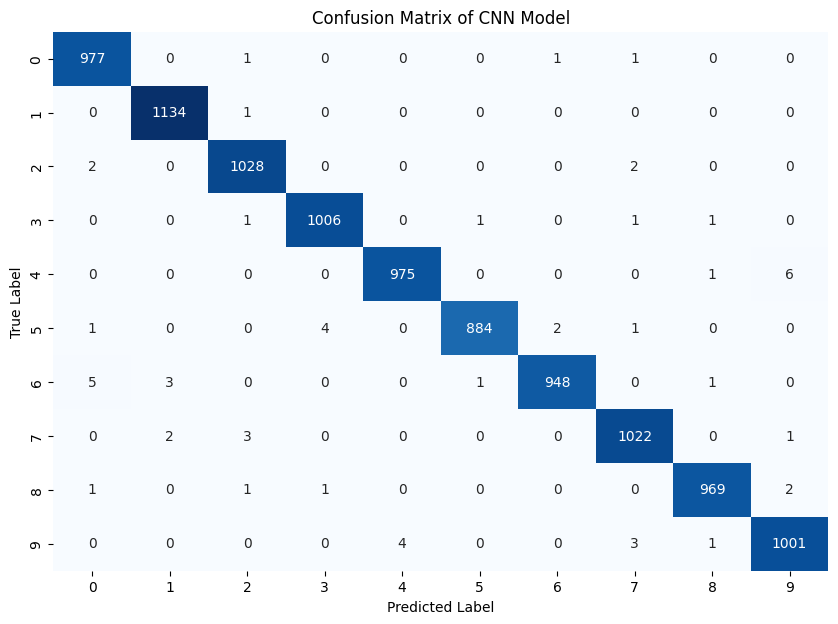

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_test_cnn, predicted_classes_cnn)

# Calculate the total number of misclassified cases
total_misclassified = np.sum(cm) - np.trace(cm)
print("Total number of misclassification cases:", total_misclassified)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix of CNN Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


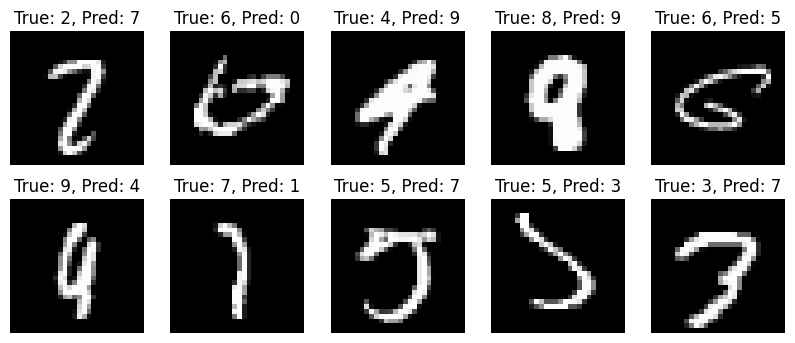

In [ ]:
# If there are misclassified samples, plot some of them
if len(misclassified_indices_cnn) > 0:
    plt.figure(figsize=(10, 4))
    for i, misclassified_index in enumerate(misclassified_indices_cnn[:10]):  # Plot first 10 misclassified digits
        plt.subplot(2, 5, i+1)
        plt.imshow(x_test_cnn[misclassified_index].reshape(28, 28), cmap='gray')
        plt.title(f"True: {y_test_cnn[misclassified_index]}, Pred: {predicted_classes_cnn[misclassified_index]}")
        plt.axis('off')
    plt.show()

else:
    print("No misclassified samples found.")


### Train Transformer on Entire Dataset


In [ ]:
trans = build_ViT(n,m,block_size,hidden_dim,num_layers,num_heads,key_dim,mlp_dim,dropout_rate,num_classes)

trans.fit([x_train_ravel_tf,pos_feed_train],y_train_tf,epochs=50,batch_size = 200)

# Evaluate on the test set
test_loss_tf, test_acc_tf = trans.evaluate([x_test_ravel_tf,pos_feed_test],y_test_tf)
print(f"Test accuracy: {test_acc*100:.2f}%")

### Visualization of Missclassification from Transformer

In [ ]:
predictions_tf = trans.predict([x_test_ravel_tf, pos_feed_test])
predicted_classes_tf = np.argmax(predictions_tf, axis=1)


cm_tf = confusion_matrix(y_test_tf, predicted_classes_tf)


313/313 [==============================] - 5s 16ms/step


Total number of misclassification cases from transformer model: 208


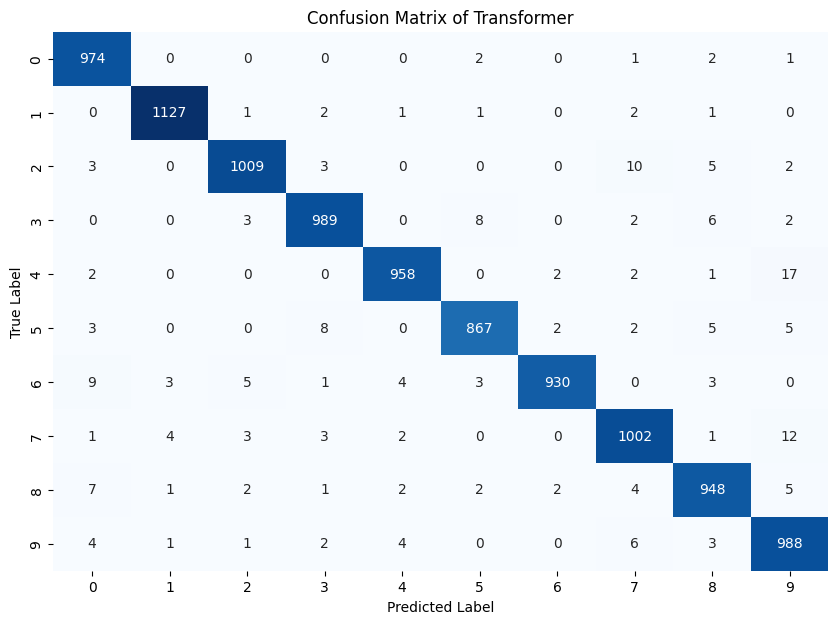

In [ ]:
total_misclassified_tf = np.sum(cm_tf) - np.trace(cm_tf)
print("Total number of misclassification cases from transformer model:", total_misclassified_tf)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_tf, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix of Transformer')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

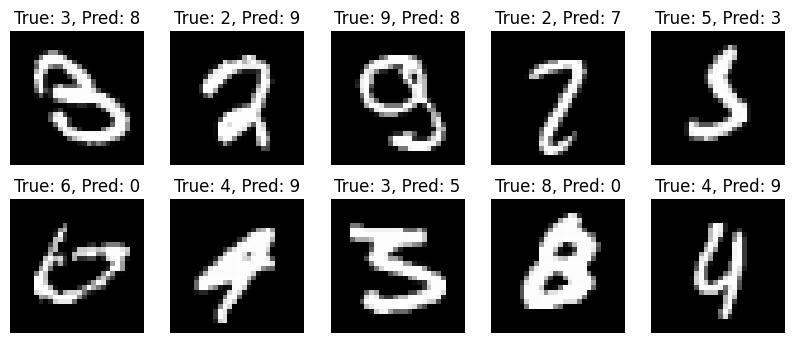

In [ ]:
misclassified_indices_tf = np.where(predicted_classes_tf != y_test_tf)[0]
plt.figure(figsize=(10, 4))
for i, misclassified_index in enumerate(misclassified_indices_tf[:10]):  # Plot first 10 misclassified digits
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_tf[misclassified_index].reshape(28, 28), cmap='gray')
    plt.title(f"True: {y_test_tf[misclassified_index]}, Pred: {predicted_classes_tf[misclassified_index]}")
    plt.axis('off')
plt.subplots_adjust()
plt.show()
